In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import surp
import matplotlib.pyplot as plt
import vice
import numpy as np
from surp.gce_math import Z_to_MH, MH_to_Z, Z_SUN
import arya

from surp.agb_interpolator import interpolator

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


# CCSNe Model

In [3]:
from surp.yield_models import Lin_CC, LogLin_CC, BiLin_CC, BiLogLin_CC, C_AGB_Model, ZeroAGB
from surp.yields import calc_y

In [4]:
def plot_y_z(Zs=Z_SUN * np.logspace(-1, 0.5, 100), ele="c", kind="line", factor = 1, **kwargs):
    mass_yields = []
    
    for Z in Zs:
        m_c, times = vice.single_stellar_population(ele, Z=Z)
        mass_yields.append(m_c[-1])
        
    y_c_agb = np.array(mass_yields)/1e6 * factor
    plt.xlabel(r"$\log Z / Z_\odot$")
    plt.ylabel(r"yield")
    if kind == "line":
        p = plt.plot(Z_to_MH(Zs), y_c_agb, **kwargs)
    elif kind == "scatter":
        p = plt.scatter(Z_to_MH(Zs), y_c_agb, **kwargs)
    return p


In [5]:
vice.yields.agb.settings["c"] = ZeroAGB()

In [6]:
y_cc = vice.yields.ccsne.settings

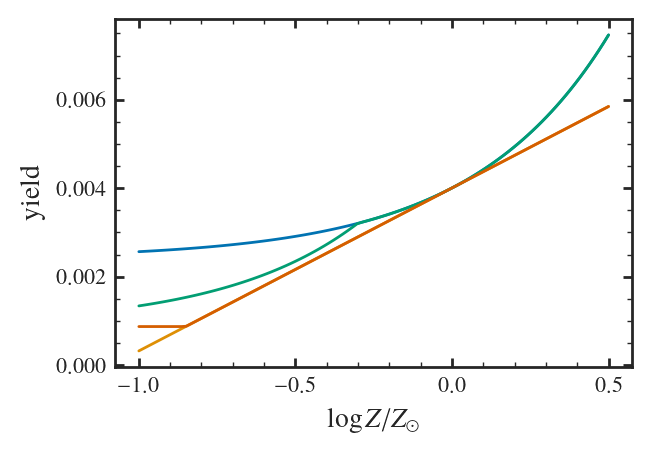

In [7]:
y_cc["c"] = Lin_CC(zeta=0.1)
plot_y_z()

y_cc["c"] = LogLin_CC(zeta=0.1)

plot_y_z(label="loglin")

y_cc["c"] = BiLin_CC(zeta=0.1)
plot_y_z(label="BiLin")

y_cc["c"] = BiLogLin_CC(zeta=0.1)
plot_y_z(label="BiLogLin")

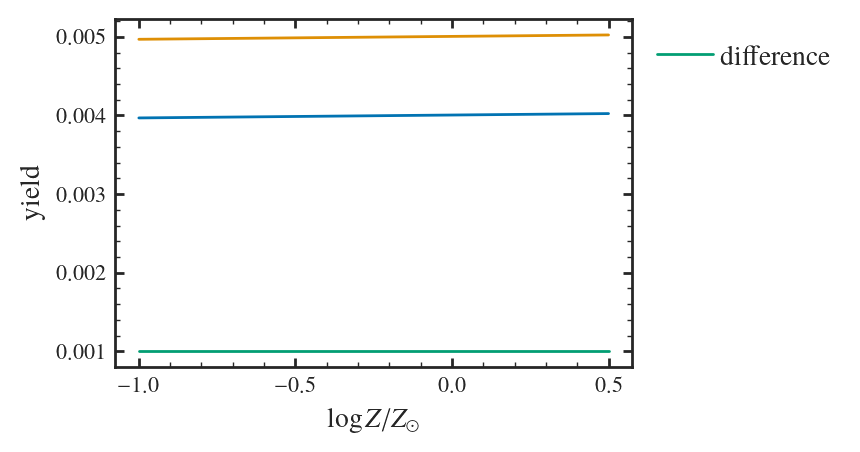

In [8]:
y_cc["c"] = LogLin_CC(zeta=0.001)

plot_y_z()

y_cc["c"] = LogLin_CC(y0 = 0.005, zeta=0.001)
plot_y_z()

y_cc["c"] = lambda Z: LogLin_CC(y0 = 0.005, zeta=0.001)(Z) - LogLin_CC(y0 = 0.004, zeta=0.001)(Z)
plot_y_z(label="difference")
arya.Legend(loc=-1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


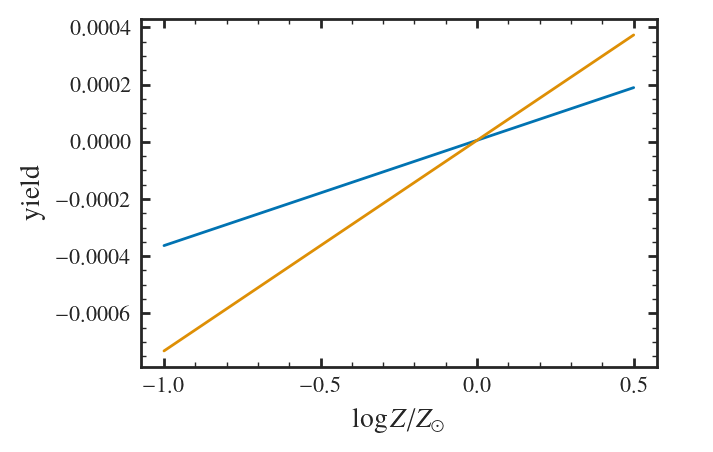

In [9]:
y_cc["c"] = LogLin_CC(y0=0, zeta=0.01)

plot_y_z()

y_cc["c"] = LogLin_CC(y0=0, zeta = 0.02)
plot_y_z()

arya.Legend(loc=-1)

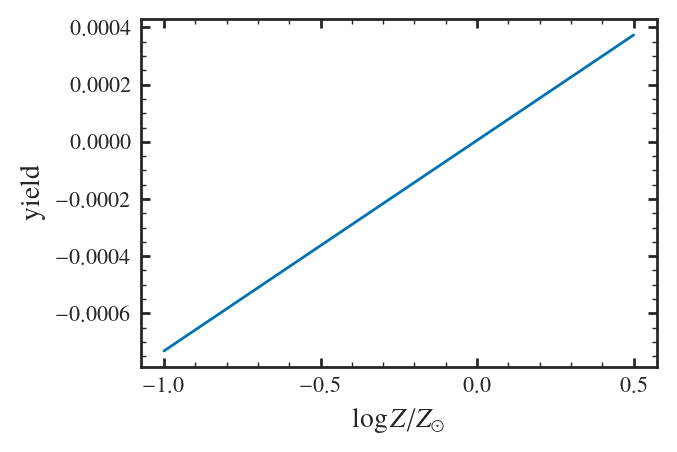

In [10]:
plot_y_z()

In [11]:
BiLin_CC()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 0.003)

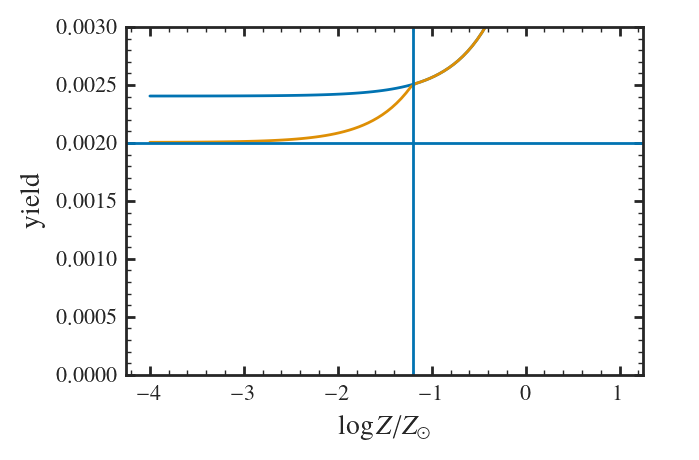

In [12]:
y_cc["c"] = Lin_CC()
Zs = MH_to_Z(np.linspace(-4, 1, 100))
plot_y_z(Zs)

y_cc["c"] = BiLin_CC(Z1=0.001, y1=2e-3)

plot_y_z(Zs,)
arya.Legend(loc=-1)
plt.axhline(2e-3)
plt.axvline(Z_to_MH(1e-3))
plt.ylim(0, 3e-3)

# AGB Interpolator

In [21]:
y_cc["c"] = 0
y_agb = vice.yields.agb.settings

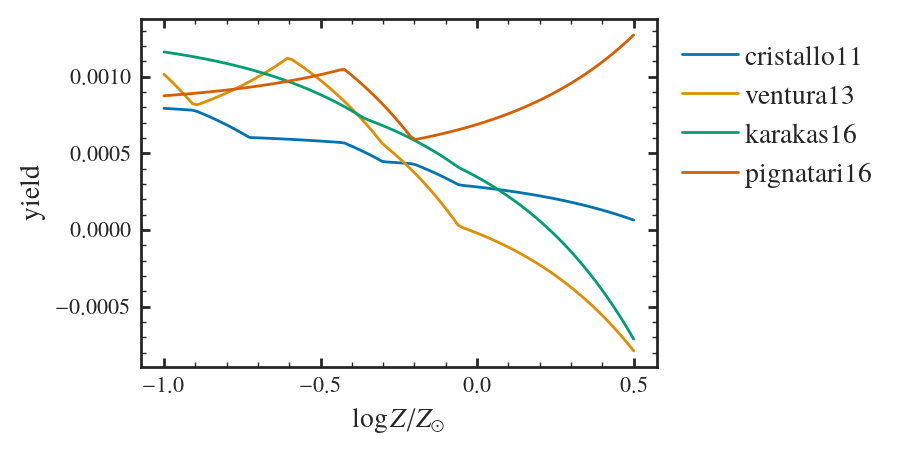

In [22]:
for study in surp.AGB_MODELS:
    
    y_agb["c"] = interpolator("c", study=study)
    plot_y_z( label=study)

arya.Legend(loc=-1)

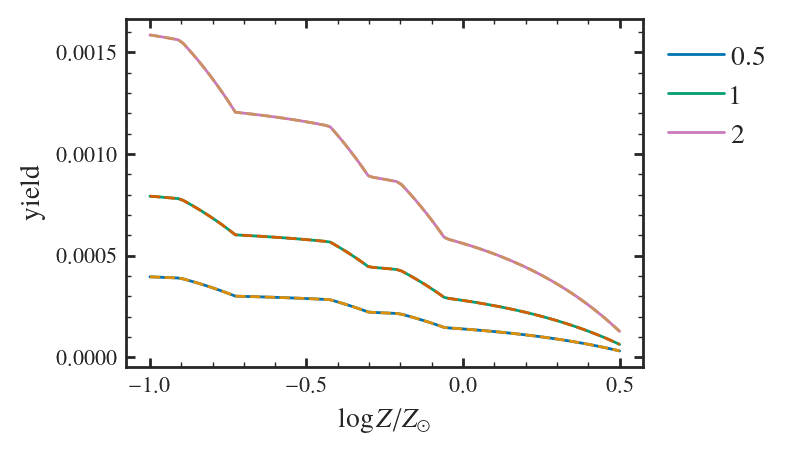

In [23]:
for alpha in [0.5, 1, 2]:
    
    y_agb["c"] = interpolator("c", prefactor=alpha)
    plot_y_z( label=alpha)
    y_agb["c"] = interpolator("c")
    y_agb["c"] = y_agb["c"]*alpha
    plot_y_z(ls="--")

arya.Legend(loc=-1)

Text(0, 0.5, 'Y')

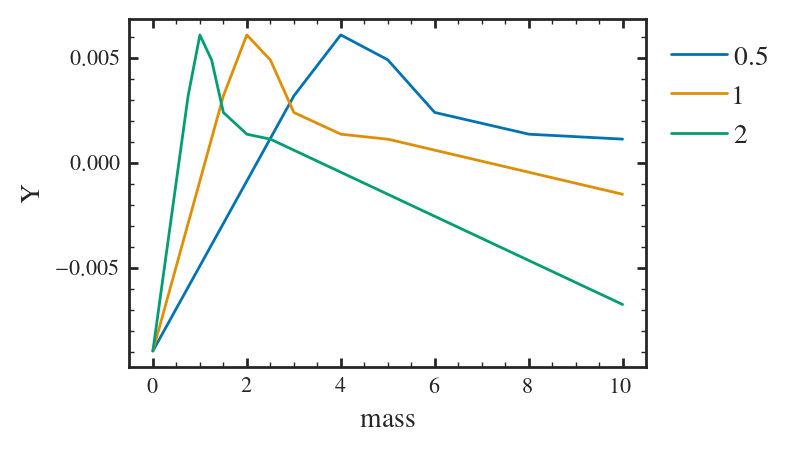

In [24]:
ms = np.linspace(0, 10, 1000)
Z = 0.1*Z_SUN
for alpha in [0.5, 1, 2]:
    y_agb["c"] = interpolator("c", mass_factor=alpha)
    plt.plot(ms, [y_agb["c"](m, Z) for m in ms], label=alpha)

arya.Legend(loc=-1)
plt.xlabel("mass")
plt.ylabel("Y")

Text(0, 0.5, 'Y')

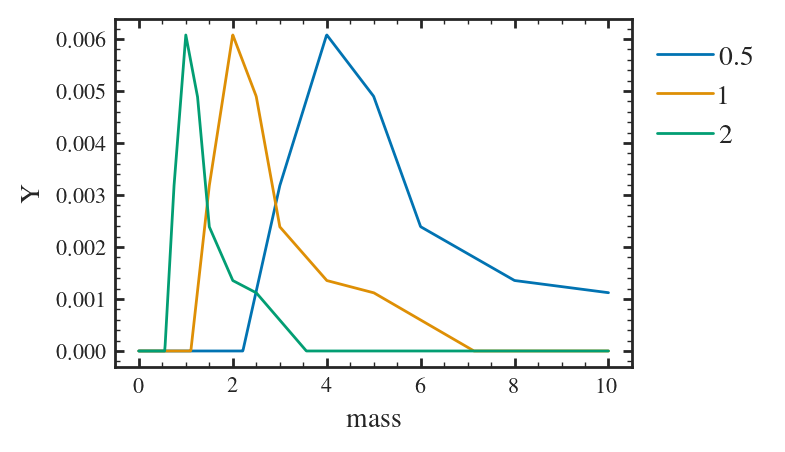

In [25]:
for alpha in [0.5, 1, 2]:
    y_agb["c"] = interpolator("c", mass_factor=alpha, no_negative=True)
    plt.plot(ms, [y_agb["c"](m, Z) for m in ms], label=alpha)

arya.Legend(loc=-1)
plt.xlabel("mass")
plt.ylabel("Y")

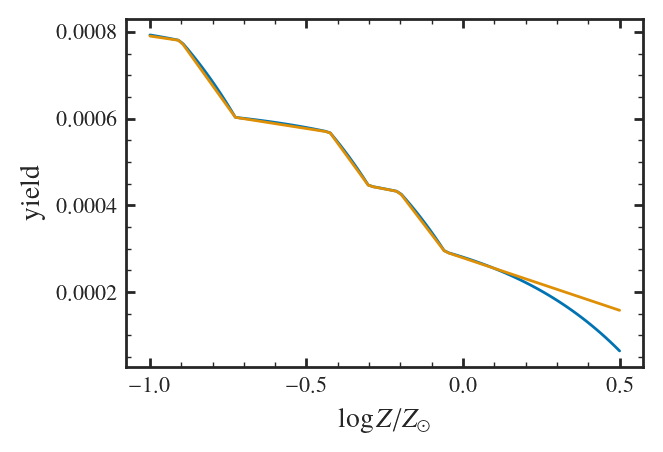

In [26]:
y_agb["c"] = interpolator("c")
plot_y_z()

y_agb["c"] = interpolator("c", interp_kind="log")
plot_y_z()

In [27]:
surp.yields.set_yields(c_cc_y0=0, c_cc_zeta=0, c_agb_model="karakas10")

In [28]:
vice.yields.agb.settings["c"]

1.00 × karakas10

# Parameters

In [29]:
import sys
sys.path.append("../../models/")
from make_yields import make_yield_params, y_c_total

In [30]:
def y(Z=Z_SUN, ele="c"):
    m_c, times = vice.single_stellar_population(ele, Z=Z, mstar=1)
    return m_c[-1]

In [31]:
def y_agb(Z=Z_SUN, ele="c"):
    yc = vice.yields.ccsne.settings[ele]
    vice.yields.ccsne.settings[ele] = 0
    
    ya = y(Z)
    
    vice.yields.ccsne.settings[ele] = yc
    return ya

def y_cc(Z=Z_SUN, ele="c"):
    ya = vice.yields.agb.settings[ele]
    vice.yields.agb.settings[ele] = surp.yield_models.ZeroAGB()
    
    yc = y(Z)
    
    vice.yields.agb.settings[ele] = ya
    return yc

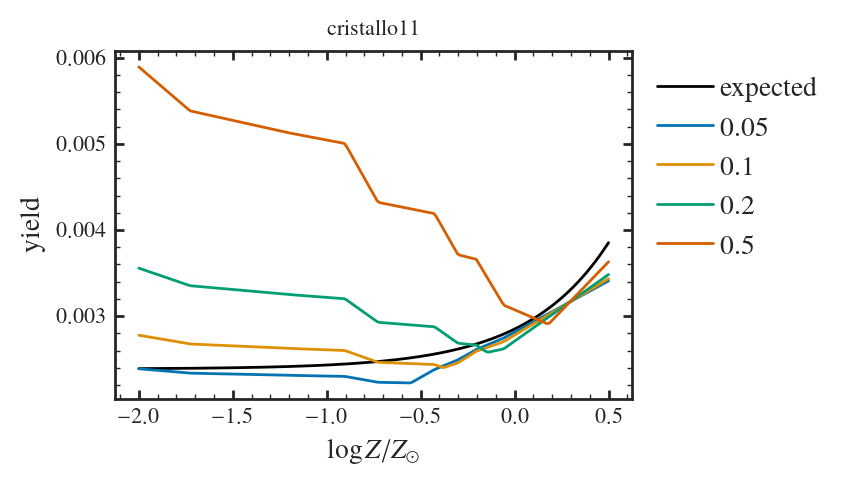

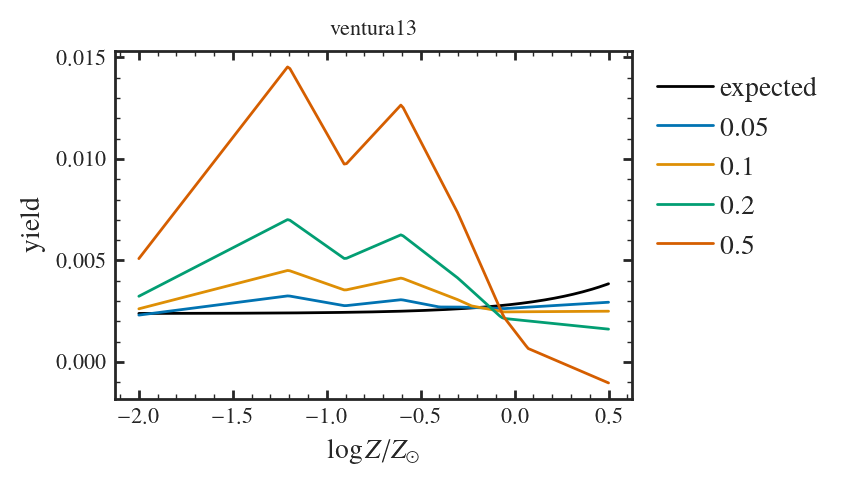

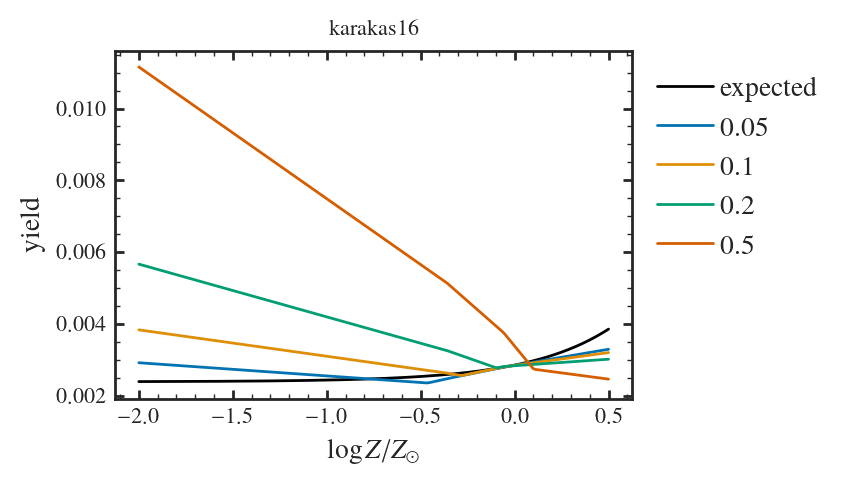

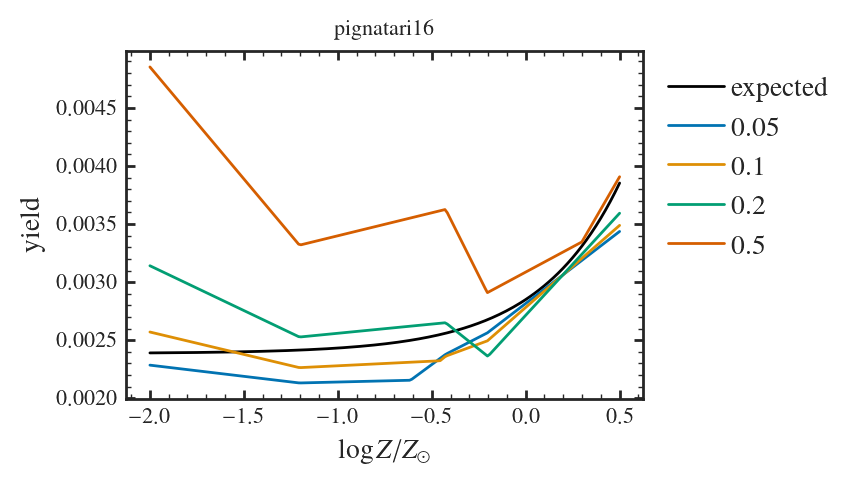

In [35]:
for agb_model in surp.AGB_MODELS:
    plt.plot(MH,y_c_total(Zs), label="expected", color="k")

    for f in [0.05, 0.1, 0.2, 0.5]:
        params = make_yield_params(f_agb=f, agb_model=agb_model, interp_kind="log", cc_model="BiLogLin", y1=0.002)
        surp.yields.set_yields(params)
        plot_y_z(Zs, label=f)

    arya.Legend(-1)
    plt.title(agb_model)
    plt.show()

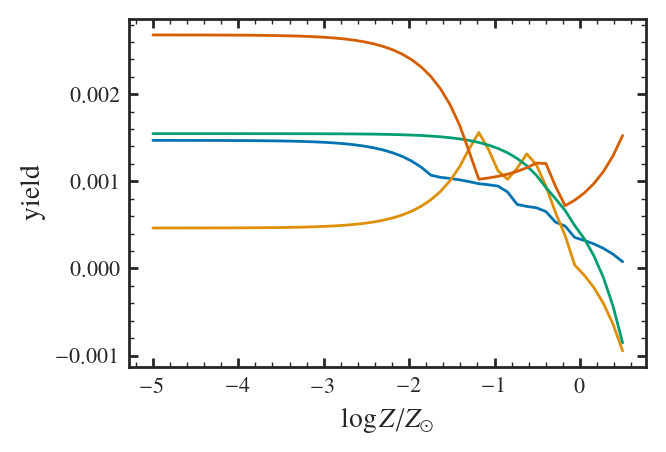

In [32]:
MH = np.linspace(-5, 0.5)
Zs = MH_to_Z(MH)

for model in surp._globals.AGB_MODELS:
    surp.yields.set_yields(make_yield_params(alpha_agb=1.2,  agb_model=model))
    vice.yields.ccsne.settings["c"] = 0
    plot_y_z(Zs)

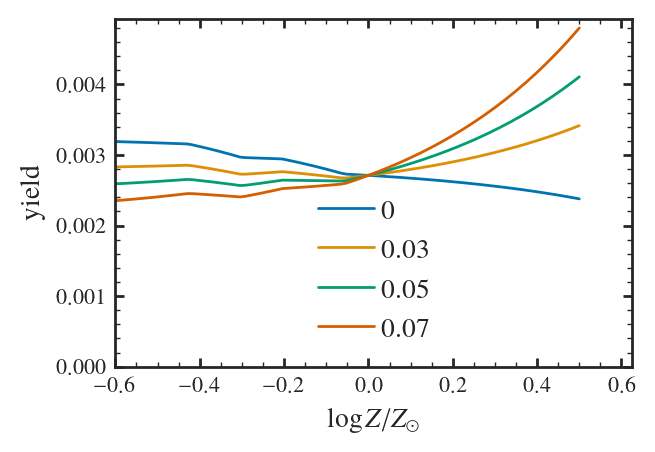

In [33]:
MH = np.linspace(-2, 0.5, 200)
Zs = MH_to_Z(MH)


for z_cc in [0, 0.03, 0.05, 0.07]:
    surp.yields.set_yields(make_yield_params(f_agb=0.2, zeta_cc=z_cc,  agb_model="cristallo11"))
    plot_y_z(Zs, label=z_cc)

plt.xlim(-0.6)
plt.ylim(0)
plt.legend()

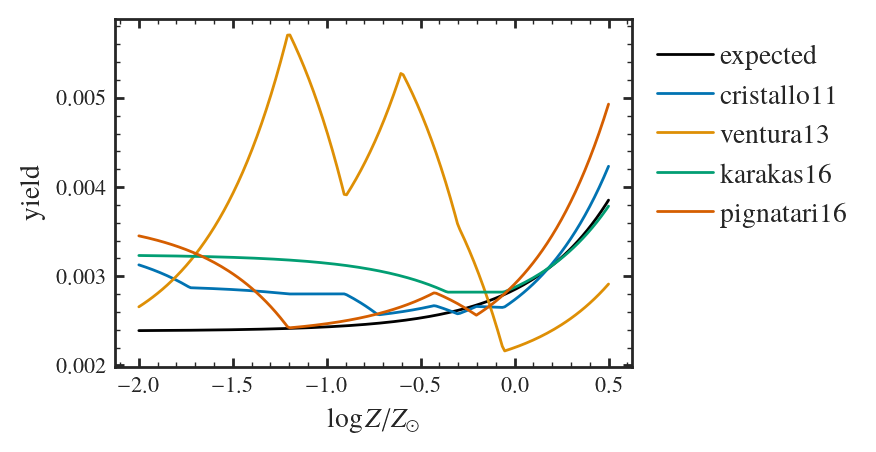

In [27]:
MH = np.linspace(-2, 0.5, 200)
Zs = MH_to_Z(MH)
plt.plot(MH,y_c_total(Zs), label="expected", color="k")

for agb_model in surp.AGB_MODELS:

    
    params = make_yield_params(agb_model=agb_model)
    surp.yields.set_yields(params)
    plot_y_z(Zs, label=agb_model)

arya.Legend(-1)


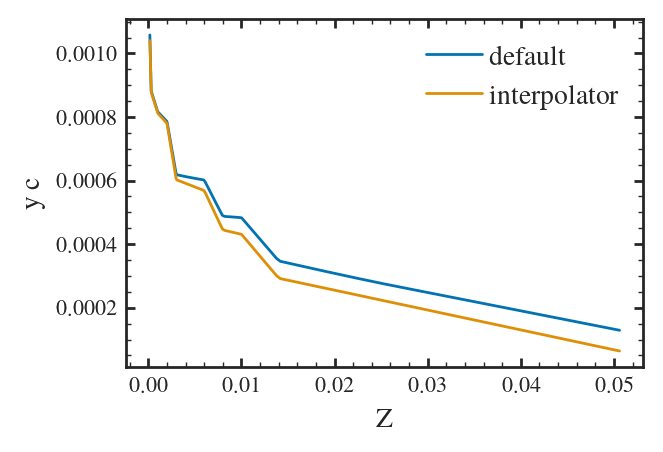

In [28]:
vice.yields.agb.settings["c"] = "cristallo11"
plt.plot(Zs, [y_agb(Z) for Z in Zs], label="default")

vice.yields.agb.settings["c"] = interpolator("c", no_negative=False)

plt.plot(Zs, [y_agb(Z)  for Z in Zs], label="interpolator")
plt.xlabel("Z")
plt.ylabel("y c")
plt.legend()